In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
#read files
file_paths = {
    "KC": "KC15March.xlsx",
    "SL": "St.Louis 15March.xlsx",
    "SF": "SanFran.March15.xlsx",
    "MO": "Missouri data.xlsx",
    "IL": "Illinois data.xlsx",
    "AZ": "Arizaona_data.xlsx"}
new_case_column = {
    "KC": "New Cases",
    "SL": "Daily cases",
    "SF": "New Cases",
    "MO": "New cases",
    "IL": "New cases",
    "AZ": "New cases"}


/var/folders/zh/3t1h17vx73nbnzrdfnvdtqm80000gn/T/ipykernel_38177/2216625115.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#define the model
def sir_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def extended_sir_model(t, y, beta, gamma, lambda1, lambda2, p1, p2):
    S, I, R = y
    f_t = lambda1 * t + lambda2
    h_t = p1 * t + p2
    dSdt = -beta * S * I + f_t
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I + h_t
    return [dSdt, dIdt, dRdt]

# Fit the residual function definition
def residuals_sir(params, t, S_data, I_data, R_data, y0):
    beta, gamma = params
    sol = solve_ivp(lambda t, y: sir_model(t, y, beta, gamma), [t[0], t[-1]], y0, t_eval=t)
    S_pred, I_pred, R_pred = sol.y
    return np.concatenate([(S_pred - S_data), (I_pred - I_data), (R_pred - R_data)])

def residuals_ext(params, t, S_data, I_data, R_data, y0, beta, gamma):
    lambda1, lambda2, p1, p2 = params
    sol = solve_ivp(lambda t, y: extended_sir_model(t, y, beta, gamma, lambda1, lambda2, p1, p2),
                    [t[0], t[-1]], y0, t_eval=t)
    S_pred, I_pred, R_pred = sol.y
    return np.concatenate([(S_pred - S_data), (I_pred - I_data), (R_pred - R_data)])


In [3]:
# data preprocess
def preprocess(df, new_col):
    df = df.iloc[:363]
    new_cases = df[new_col].fillna(0).to_numpy()
    T = len(new_cases)
    I = np.array([np.sum(new_cases[max(0, i - 13):i + 1]) for i in range(T)])
    R = np.array([np.sum(new_cases[:max(0, i - 13)]) for i in range(T)])
    N = (I + R).max() * 1.2
    S = N - I - R
    return np.arange(T), S / N, I / N, R / N, [S[0]/N, I[0]/N, R[0]/N], N

# Two-step fitting
results = {}

for city, path in file_paths.items():
    try:
        df = pd.read_excel(path)
        col = new_case_column[city]
        t, S, I, R, y0, N = preprocess(df, col)

        res_sir = least_squares(residuals_sir,x0=[0.5, 0.1],args=(t, S, I, R, y0),method='trf')
        beta, gamma = res_sir.x

        # fix β, γ to fit λ₁, λ₂, p₁, p₂
        res_ext = least_squares(
            residuals_ext,x0=[1, 0, 1, 0],args=(t, S, I, R, y0, beta, gamma),method='trf')
        lambda1, lambda2, p1, p2 = res_ext.x

        results[city] = {"β": beta,"γ": gamma,"λ1": lambda1 * N,"λ2": lambda2 * N,"p1": p1 * N,"p2": p2 * N}

    except Exception as e:
        results[city] = f"ERROR: {e}"

#results
table2 = pd.DataFrame({k: v for k, v in results.items() if isinstance(v, dict)}).T
table2 = table2[["β", "γ", "λ1", "λ2", "p1", "p2"]].round(4)
table2

,β,γ,λ1,λ2,p1,p2
KC,0.5000,0.1000,-0.7032,10.1051,0.7479,-23.7989
SL,0.1114,0.0677,-0.1744,-12.8293,0.2396,0.1707
SF,0.5000,0.1000,-0.5424,3.1952,0.5251,-8.1812
MO,0.5000,0.1000,-10.6837,404.2204,11.0215,-553.8197
IL,0.5000,0.1000,-22.9098,548.8747,23.1699,-836.8537
AZ,0.5000,0.1000,-14.7610,425.7636,13.9149,-494.6388


In [4]:
#define g(t)
def g_cosine(t, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    return (a1 * b1 * np.cos(b1 * t + c1) +a2 * b2 * np.cos(b2 * t + c2) +a3 * b3 * np.cos(b3 * t + c3))
def compute_I_residual(t, S_data, I_data, R_data, y0, beta, gamma, lambda1, lambda2, p1, p2):
    def model(t, y):
        S, I, R = y
        f = lambda1 * t + lambda2
        h = p1 * t + p2
        dSdt = -beta * S * I + f
        dIdt = beta * S * I - gamma * I
        dRdt = gamma * I + h
        return [dSdt, dIdt, dRdt]

    sol = solve_ivp(model, [t[0], t[-1]], y0, t_eval=t)
    _, I_pred, _ = sol.y
    return I_data - I_pred  


In [5]:
# Fitting
table3_results = {}

for city, path in file_paths.items():
    try:
        df = pd.read_excel(path)
        col = new_case_column[city]
        t, S, I, R, y0, N = preprocess(df, col)
        
        # Retrieve fitted parameters
        beta = results[city]["β"]
        gamma = results[city]["γ"]
        lambda1 = results[city]["λ1"] / N
        lambda2 = results[city]["λ2"] / N
        p1 = results[city]["p1"] / N
        p2 = results[city]["p2"] / N
        
        # Compute g(t) data (residual for fitting)
        g_data = compute_I_residual(t, S, I, R, y0, beta, gamma, lambda1, lambda2, p1, p2)

        # Initial parameter guess for fitting
        guess = [1000, 0.01, 0, 1000, 0.05, 0, 1000, 0.025, 0]
        popt, _ = curve_fit(g_cosine, t, g_data, p0=guess, maxfev=10000)

        a1, b1, c1, a2, b2, c2, a3, b3, c3 = popt
        T1, T2, T3 = 2 * np.pi / b1, 2 * np.pi / b2, 2 * np.pi / b3

        table3_results[city] = {
            "a1": a1, "b1": b1, "c1": c1, "T1": T1,
            "a2": a2, "b2": b2, "c2": c2, "T2": T2,
            "a3": a3, "b3": b3, "c3": c3, "T3": T3,
        }

    except Exception as e:
        print(f"[ERROR] g(t) fitting failed for {city} - {e}")

# Compile fitting results into DataFrame
table3 = pd.DataFrame(table3_results).T
table3 = table3[["a1", "b1", "c1", "T1", "a2", "b2", "c2", "T2", "a3", "b3", "c3", "T3"]].round(4)
table3


,a1,b1,c1,T1,a2,b2,c2,T2,a3,b3,c3,T3
KC,-5.9546,0.0092,0.9798,682.3637,0.2988,0.0466,-0.2220,134.9470,0.7432,0.0253,-1.0295,248.0737
SL,-4.1596,0.0111,0.6535,567.2627,0.3747,0.0494,-1.0116,127.2476,1.3871,0.0232,-1.2603,270.7791
SF,-10.4146,0.0047,1.3982,1347.4051,-161.7621,0.0373,2.8643,168.3591,161.8260,0.0373,-3.4151,168.5340
MO,-6.0735,0.0094,0.8730,669.7193,0.2525,0.0485,-0.7865,129.5159,0.9017,0.0250,-0.8262,251.0254
IL,-12.0102,0.0051,1.2319,1231.4674,0.3001,0.0477,-0.8445,131.6647,0.8723,0.0310,-1.9370,202.9272
AZ,34.4504,0.0279,-1.2891,225.1517,-32.7586,0.0285,4.9371,220.6256,-4.7111,0.0141,0.4647,445.4423


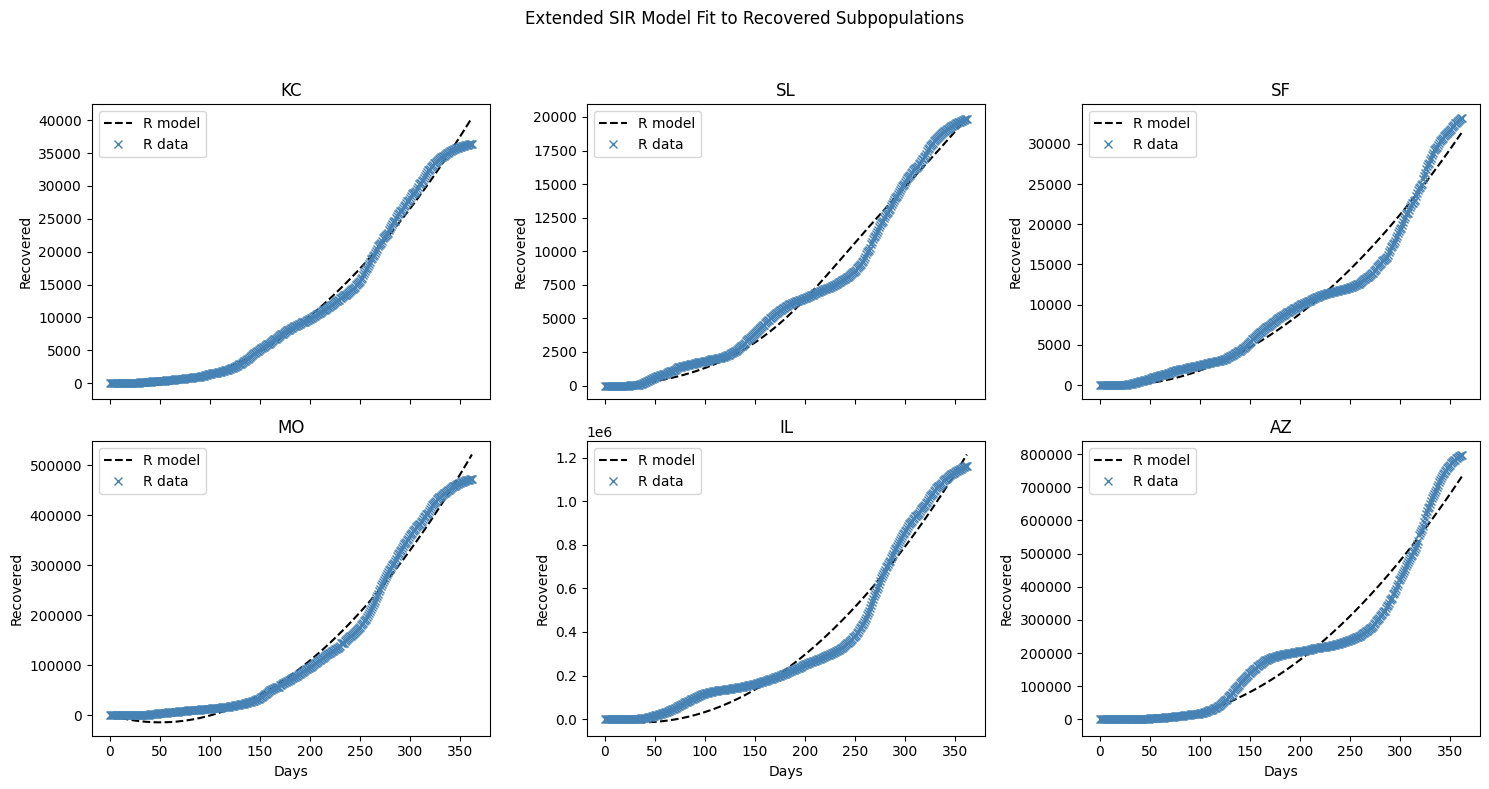

In [6]:

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -- Make sure you've already run the previous fitting code to obtain `results` and `preprocess` --

file_paths = {
    "KC": "KC15March.xlsx",
    "SL": "St.Louis 15March.xlsx",
    "SF": "SanFran.March15.xlsx",
    "MO": "Missouri data.xlsx",
    "IL": "Illinois data.xlsx",
    "AZ": "Arizaona_data.xlsx"
}
new_case_column = {
    "KC": "New Cases",
    "SL": "Daily cases",
    "SF": "New Cases",
    "MO": "New cases",
    "IL": "New cases",
    "AZ": "New cases"
}

def extended_sir_model(t, y, beta, gamma, lam1, lam2, p1, p2):
    S, I, R = y
    f_t = lam1 * t + lam2
    h_t = p1 * t + p2
    dSdt = -beta * S * I + f_t
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I + h_t
    return [dSdt, dIdt, dRdt]

# Create a 2×3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=False)

for ax, (city, path) in zip(axes.flatten(), file_paths.items()):
    # 1. Load and preprocess data
    df = pd.read_excel(path)
    t, S_norm, I_norm, R_norm, y0, N = preprocess(df, new_case_column[city])
    
    # 2. Extract fitted parameters and denormalize
    beta = results[city]["β"]
    gamma = results[city]["γ"]
    lam1 = results[city]["λ1"] / N
    lam2 = results[city]["λ2"] / N
    p1   = results[city]["p1"] / N
    p2   = results[city]["p2"] / N
    
    # 3. Simulate the extended SIR model
    sol = solve_ivp(lambda t, y: extended_sir_model(t, y, beta, gamma, lam1, lam2, p1, p2),
                    [t[0], t[-1]], y0, t_eval=t)
    R_model = sol.y[2] * N  # Denormalize to actual population size
    
    # 4. Plot model prediction and actual data
    ax.plot(t, R_model, 'k--', linewidth=1.5, label='R model')
    ax.plot(t, R_norm * N, 'x', color='steelblue', label='R data')
    ax.set_title(city)
    ax.set_ylabel('Recovered')
    ax.legend(loc='upper left')

# Set common X-axis label
for ax in axes[1]:
    ax.set_xlabel('Days')
plt.suptitle('Extended SIR Model Fit to Recovered Subpopulations')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

